<a href="https://colab.research.google.com/github/khodid/2020Evening/blob/master/proj4_2_VAE_scenery_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 학습 이후 활동
- 작성일 : 2020년 8월 23일

1. 벡터 연산 해보기
2. 두 이미지 합성 해보기

## Gdrive 연동 및 데이터셋 불러오기

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(-0.5, 47.5, 47.5, -0.5)

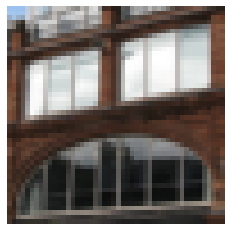

In [14]:
import torchvision
from torchvision import transforms

root = '/content/gdrive/My Drive/Kaggle/scene-classification/train-scene classification/train'

trans= transforms.Compose([
                              transforms.Resize([48, 48]),
                              transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root = root, transform= trans)

import matplotlib.pyplot as plt
showimg = train_data[10][0].numpy().transpose(1,2,0)

plt.imshow(showimg) # train_data[순서][0: 이미지 / 1: 라벨]
plt.axis('off')

In [37]:
batch_size = 20
train_set = torch.utils.data.DataLoader(train_data, batch_size= batch_size, shuffle = False)

## .py로 만들었어야 했던 코드들

In [28]:
def load_model(l_size, MODEL_PATH):
  model = VAE(latent_size= l_size)
  optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.001)

  checkpoint = torch.load(MODEL_PATH, map_location = device)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  return model, optimizer, epoch, loss

In [21]:
import torch.nn as nn

class VAE(nn.Module):
  def __init__(self, latent_size):
    super(VAE, self).__init__()
    self.latent_size = latent_size
    self.encoder = nn.Sequential(
                                  # layer 1
                                  nn.Conv2d(3, 16, kernel_size = 5, stride = 1, padding = 2), # 3(48, 48) -> 16(48, 48)
                                  nn.BatchNorm2d(16),
                                  nn.ReLU(),
                                  
                                  #layer 2
                                  nn.Conv2d(16, 32, kernel_size = 5, stride = 2, padding=2), # 16(48, 48) -> 32(24, 24)
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),

                                  # layer 3
                                  nn. Conv2d(32, 32, kernel_size= 3, stride = 2, padding = 1), # 32(24, 24) -> 32(12, 12)
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),

                                  # output layer
                                  nn.Flatten()  # 32*12*12 = 4608
    )
    self.fc_mu = nn.Linear(4608, self.latent_size)
    self.fc_logvar = nn.Linear(4608, self.latent_size)
    self.fc_decode = nn.Linear(self.latent_size, 4608)
    self.decoder = nn.Sequential(
                                  # 
                                  # 3-T
                                  nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 2, padding=1, output_padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.LeakyReLU(),

                                  # 2-T
                                  nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
                                  nn.BatchNorm2d(16),
                                  nn.LeakyReLU(),

                                  # 1-T
                                  nn.ConvTranspose2d(16, 3, kernel_size=5, stride=1, padding=2),
                                  nn.Sigmoid()
    )
  def reparameterize(self, mu, var):
    sigma = torch.exp(0.5*var)
    epsilon = torch.randn_like(sigma)
    return mu + sigma * epsilon

  def encode(self, img):
    h = self.encoder(img)
    mu, log_var = self.fc_mu(h), self.fc_logvar(h)
    z = self.reparameterize(mu, log_var)
    return z, mu, log_var

  def decode(self, z):
    z = self.fc_decode(z)
    new_img = self.decoder(z.view(z.size(0), 32, 12, 12))
    return new_img

## 모델 불러오기(from proj4_VAE_scenery.ipynb)


In [17]:
# 디바이스 설정
import torch.cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda' : torch.cuda.manual_seed_all(777)

In [18]:
MODEL_PATH = '/content/gdrive/My Drive/Kaggle/scene-classification/vae_model.pth'

In [29]:
import torch
model, optimizer, epoch, loss = load_model(200, MODEL_PATH)
model = model.to(device)

제대로 불러온 건지 확인!

In [43]:
item = iter(train_set)

In [47]:
img, label = next(item)

In [48]:
label

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

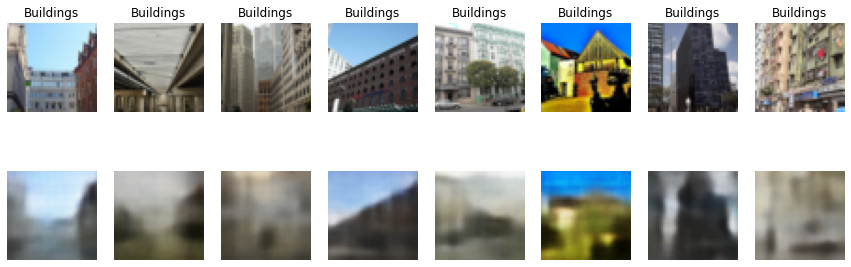

In [49]:


with torch.no_grad():
    if device == 'cuda': img = img.to(device)
    
    z, mu, var = model.encode(img)
    new_img = model.decode(z)

    if device == 'cuda': img, new_img = img.cpu(), new_img.cpu()
    show_original_set = img.view(img.size(0), 3, 48, 48).numpy().transpose(0, 2,3,1)
    show_gen_set = new_img.view(new_img.size(0), 3, 48, 48).numpy().transpose(0,2,3,1)
    
    plt.figure(figsize=(15, 5))
    for i in range(8):
      show_original = show_original_set[i]
      show_gen = show_gen_set[i]

      plt.subplot(2, 8, i+1)
      plt.title('{}'.format(tags[label[i]]))
      plt.imshow(show_original, cmap='gray')
      plt.axis(False)
      plt.subplot(2, 8, i + 9)
      plt.imshow(show_gen, cmap = 'gray')
      plt.axis(False)